In [1]:
import re
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)
    
print(tf.__version__)

Number of replicas: 1
2.5.0


In [3]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
GCS_PATH = '../imagens'
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
IMAGE_SIZE = [180, 180]
EPOCHS = 25

In [4]:
filenames = tf.io.gfile.glob(str(GCS_PATH + '/40X_treino/*/*'))
filenames.extend(tf.io.gfile.glob(str(GCS_PATH + '/VAL_40/*/*')))
train_filenames, val_filenames = train_test_split(filenames, test_size=0.3)

In [5]:
COUNT_Benigno = len([filename for filename in val_filenames if "SOB_B" in filename])
print("Normal images count in training set: " + str(COUNT_Benigno))

COUNT_maligno = len([filename for filename in val_filenames if "SOB_M" in filename])
print("Cancer images count in training set: " + str(COUNT_maligno))

Normal images count in training set: 132
Cancer images count in training set: 255


In [6]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [7]:
for f in train_list_ds.take(5):
    print(f.numpy())

b'..\\imagens\\40X_treino\\M\\SOB_M_MC-14-10147-40-008.png'
b'..\\imagens\\40X_treino\\M\\SOB_M_DC-14-5287-40-001.png'
b'..\\imagens\\40X_treino\\B\\SOB_B_F-14-14134E-40-025.png'
b'..\\imagens\\40X_treino\\M\\SOB_M_PC-14-9146-40-006.png'
b'..\\imagens\\40X_treino\\M\\SOB_M_MC-14-13418DE-40-011.png'


In [8]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print("Training images count: " + str(TRAIN_IMG_COUNT))

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print("Validating images count: " + str(VAL_IMG_COUNT))

Training images count: 901
Validating images count: 387


In [10]:
CLASS_NAMES = np.array([str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1]
                        for item in tf.io.gfile.glob(str(GCS_PATH + '/40X_treino/*'))])
CLASS_NAMES

array(['B', 'M'], dtype='<U1')

In [11]:
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    return parts[-2] == "M"

In [12]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, IMAGE_SIZE)

In [13]:
def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [14]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [15]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  True


In [17]:
test_list_ds = tf.data.Dataset.list_files(str(GCS_PATH + '/40X_teste/*/*'))
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

TEST_IMAGE_COUNT

745

In [18]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    # Repeat forever
    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

In [19]:
train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

image_batch, label_batch = next(iter(train_ds))

In [38]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(15):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("M")
        else:
            plt.title("B")
        plt.axis("off")

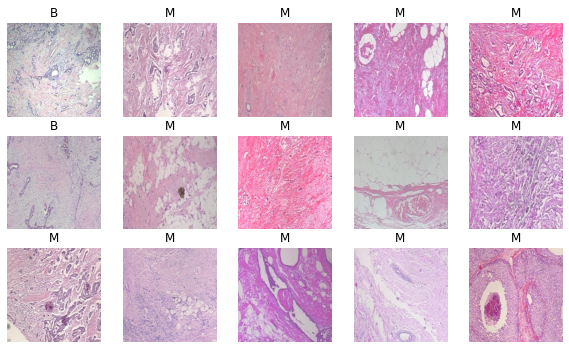

In [39]:
show_batch(image_batch.numpy(), label_batch.numpy())

# Modelo CNN com uma camada densa e um convolution block 

In [40]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )
    
    return block

In [41]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [42]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [44]:
initial_bias = np.log([COUNT_maligno/COUNT_Benigno])
initial_bias

array([0.65846162])

In [45]:
weight_for_0 = (1 / COUNT_Benigno)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_maligno)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 3.41
Weight for class 1: 1.77


In [46]:
with strategy.scope():
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [47]:
history = model.fit(
    train_ds,
    steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_ds,
    validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
    class_weight=class_weight,
)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/25
56/56 [==============================] - 44s 739ms/step - loss: 1.7926 - accuracy: 0.6094 - precision: 0.8050 - recall: 0.5991 - val_loss: 0.6420 - val_accuracy: 0.6589 - val_precision: 0.6589 - val_recall: 1.0000
Epoch 2/25
56/56 [==============================] - 41s 737ms/step - loss: 1.4632 - accuracy: 0.7132 - precision: 0.8566 - recall: 0.7188 - val_loss: 0.6658 - val_accuracy: 0.6615 - val_precision: 0.6615 - val_recall: 1.0000
Epoch 3/25
56/56 [==============================] - 40s 713ms/step - loss: 1.3930 - accuracy: 0.7243 - precision: 0.8566 - recall: 0.7375 - val_loss: 0.7037 - val_accuracy: 0.6562 - val_precision: 0.6562 - val_recall: 1.0000
Epoch 4/25
56/56 [==============================] - 40s 717ms/step - loss: 1.2914 - accuracy: 0.7824 - precision: 0.8790 - recall: 0.8062 - val_loss: 0.7223 - val_accuracy: 0.6589 - val_p

In [48]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("cancer_mama_40_model.h5",
                                                    save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)

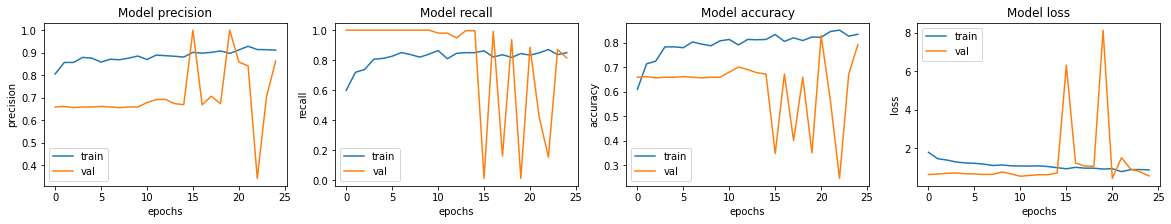

In [49]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [50]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

In [51]:
history = model.fit(
    train_ds,
    steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
    epochs=50,
    validation_data=val_ds,
    validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
    class_weight=class_weight,
    callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler]
)

Epoch 1/50
56/56 [==============================] - 39s 701ms/step - loss: 1.3984 - accuracy: 0.7266 - precision: 0.8137 - recall: 0.7997 - val_loss: 3479.2063 - val_accuracy: 0.3411 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
56/56 [==============================] - 40s 708ms/step - loss: 1.2712 - accuracy: 0.7656 - precision: 0.8341 - recall: 0.8393 - val_loss: 14.1748 - val_accuracy: 0.3385 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/50
56/56 [==============================] - 39s 700ms/step - loss: 1.2043 - accuracy: 0.7824 - precision: 0.8565 - recall: 0.8364 - val_loss: 27.3318 - val_accuracy: 0.3411 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/50
56/56 [==============================] - 39s 703ms/step - loss: 1.1807 - accuracy: 0.7868 - precision: 0.8648 - recall: 0.8310 - val_loss: 2.6497 - val_accuracy: 0.3438 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/50
56/56 [==============================] - 39s 695ms/s

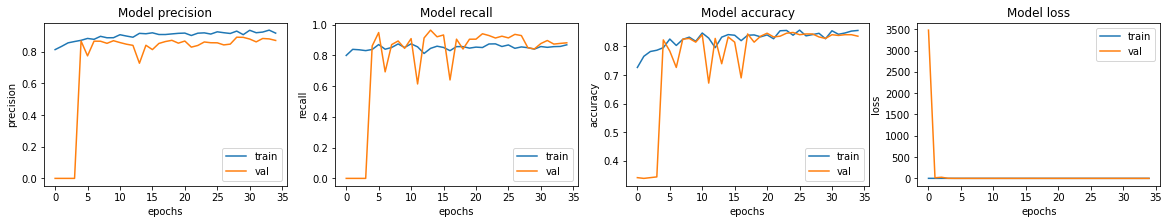

In [52]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])